## ML1 Hackathon Starter Colab
### Date: December 15, 2025
### DSBA+ICEF, HSE University

<small><font color=gray>Notebook authors: <a href="https://www.hse.ru/org/persons/223536224" target="_blank">Andrey Shevelev</a>, <a href="https://www.hse.ru/en/staff/aboldyrev" target="_blank">Alexey Boldyrev</a>, <a href="https://www.hse.ru/en/staff/sara" target="_blank">Saraa Ali</a>, <a href="http://wiki.cs.hse.ru/Machine_Learning_1_DSBA_2025/2026" target="_blank">Adamey Laypanov</a>

[**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the Hackathon ends) with other students/instructors for educational purposes.

In [121]:
# from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

In [122]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                                 # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log   # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                         # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                                    # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v ml-1-hackathon                 # hackathon dataset
!kaggle competitions download >> log                                # download competition dataset as a zip file
!unzip -o *.zip >> log                                              # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                             # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.
Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [123]:
%%time
# %reset -f
import numpy as np, pandas as pd, time
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

ToCSV = lambda df, fname: df.round(5).to_csv(f'{fname}.csv', index_label='id') # rounds values to 5 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=120): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'display.max_colwidth', 100, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 197 µs, sys: 0 ns, total: 197 µs
Wall time: 201 µs


In [124]:
df_train = pd. read_csv('X_train.csv', index_col='id' )
df_test = pd. read_csv( 'X_test.csv', index_col='id')
df_y_train = pd.read_csv('y_train.csv', index_col='id')

# Electromagnetic Calorimeter Particle Position Reconstruction Task

## Task Overview

Your goal is to **predict the entry position of particles into an electromagnetic calorimeter** based on the energy deposits recorded in the detector cells. This is a **regression problem** where you must estimate the $x$ and $y$ coordinates of particle entry points with high precision.

## Background: The Physical System

Particles passing through matter lose energy through interactions. An **electromagnetic calorimeter** is a detector designed to measure this energy loss by recording how much energy deposits in each of its cells. When a high-energy particle enters the calorimeter, it typically affects many cells; a low-energy particle affects fewer cells. The collection of cells that register energy from a single particle is called a **calorimetric cluster**.

## Calorimeter Specifications

The calorimeter has the following physical dimensions and structure:

- **Total size**: 60.6 cm × 60.6 cm
- **Number of cells**: 225 (arranged in a 15 × 15 grid)
- **Cell size**: 4.04 cm × 4.04 cm
- **Coordinate system origin**: Located at the center of the central cell

## Dataset Characteristics

The dataset represents simulated particle interactions. Key properties:

- All particles enter the **central region** of the calorimeter (an area slightly larger than a single cell)
- Particles hit the calorimeter at **varying angles of incidence**
- For each particle, you are provided with **energy deposits in all cells** that form the calorimetric cluster
- Your task is to use this information to reconstruct the particle's entry position

## Key Insight: Super-Resolution Reconstruction

Although the calorimeter cells are 4.04 cm × 4.04 cm, it is **possible to achieve position resolution significantly better than the cell size**. This is achieved by analyzing the *pattern* of energy distribution across multiple cells. Particles entering near a cell boundary will create a distinct energy signature compared to particles entering at the cell center, allowing for sub-cell-level position reconstruction.

## Evaluation Metric

Your model's performance is assessed using **Mean Columnwise Root Mean Squared Error (MCRMSE)**:

$$\text{Metric} = \frac{1}{2}\left(\text{RMSE}_x + \text{RMSE}_y\right)$$

where $\text{RMSE}_x$ and $\text{RMSE}_y$ are the root mean squared errors for the $x$ and $y$ coordinates respectively. This metric averages the prediction errors across both spatial dimensions.

## Your Challenge

Develop a machine learning model that takes the calorimeter cell energy deposits as input and outputs accurate predictions of particle entry coordinates $(x, y)$. Your goal is to minimize the Mean Columnwise RMSE, demonstrating that you can exploit the information in the energy distribution pattern to achieve precision better than the physical cell size.

Let's examine the event in the calorimeter.

* The `[0, 0]` index of the 2D array is in the lower left corner of the Axes
    * Parameter `origin='lower'`
* The red square corresponds to the central cell of the calorimeter, `[7, 7]` index
* The white cross corresponds to the particle entry point (target)

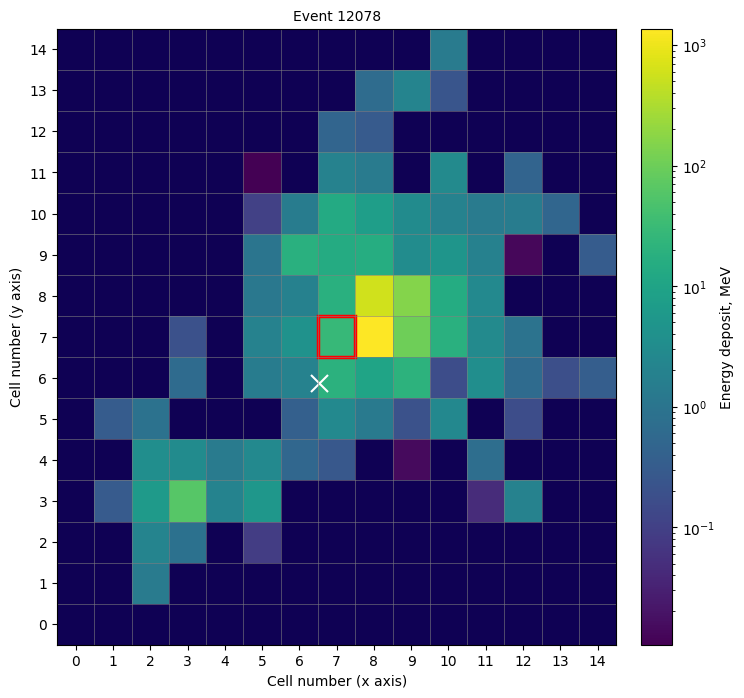

In [125]:
fig, ax = plt.subplots(figsize=(8, 8))

idx = np.random.choice(len(df_train), size=1, replace=False)[0]

data = df_train.iloc[idx].values.reshape(15, 15)

# Create cell edges for pcolormesh
x_edges = np.arange(16) - 0.5  # [-0.5, 0.5, 1.5, ..., 14.5]
y_edges = np.arange(16) - 0.5

# Use pcolormesh for precise cell boundary alignment
im = ax.pcolormesh(
    x_edges, y_edges, data,
    cmap='viridis',
    norm=LogNorm(vmin=data[data > 0].min(), vmax=data.max()),
    shading='flat'
)
ax.set_facecolor("#0F0154")
rect = Rectangle((6.5, 6.5), 1, 1, linewidth=2.5, edgecolor='red', facecolor='none')
ax.add_patch(rect)

ax.scatter(
    7 - df_y_train.iloc[idx].values[0]/4.04,
    7 - df_y_train.iloc[idx].values[1]/4.04,
    color='white', marker='x', s=150) # Target point

ax.set_xticks(np.arange(15))
ax.set_yticks(np.arange(15))

grid_lines = np.arange(-0.5, 15, 1)
ax.vlines(grid_lines, -0.5, 14.5, color='grey', linestyle='-', linewidth=0.4)
ax.hlines(grid_lines, -0.5, 14.5, color='grey', linestyle='-', linewidth=0.4)

ax.set_xlabel('Cell number (x axis)')
ax.set_ylabel('Cell number (y axis)')
ax.set_title(f'Event {idx}', fontsize=10)

cbar = fig.colorbar(im, ax=ax, fraction=0.058, pad=0.04)
cbar.set_label('Energy deposit, MeV')

plt.show()

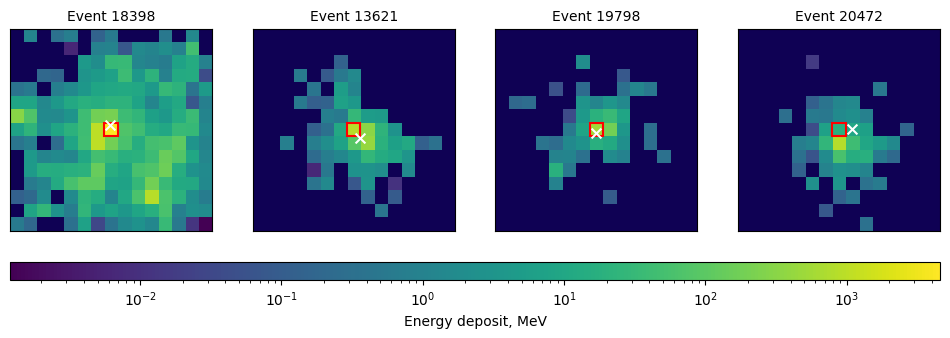

In [126]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

random_indices = np.random.choice(len(df_train), size=4, replace=False)

# Find common min/max for consistent colorbar
all_data = [df_train.iloc[idx].values.reshape(15, 15) for idx in random_indices]
vmin = min(data[data > 0].min() for data in all_data if (data > 0).any())
vmax = max(data.max() for data in all_data)

for idx, ax in zip(random_indices, axes):
    data = df_train.iloc[idx].values.reshape(15, 15)
    masked_data = np.ma.masked_where(data == 0, data)

    im = ax.imshow(masked_data, cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax), origin='lower')

    ax.set_facecolor("#0F0154")
    rect = Rectangle((6.5, 6.5), 1, 1, linewidth=1.5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    ax.scatter(
        7 - df_y_train.iloc[idx].values[0]/4.04, \
        7 - df_y_train.iloc[idx].values[1]/4.04,
        color='white', marker='x', s=50)

    ax.set_title(f'Event {idx}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# Add one horizontal colorbar below all subplots
fig.colorbar(im, ax=axes, orientation='horizontal', \
             fraction=0.08, aspect=50, pad=0.1, label='Energy deposit, MeV')

plt.show()

Examine how the target is distributed. As before, the red square corresponds to the central cell of the calorimeter.

Text(0.5, 1.0, 'Target points distribution in XY plane')

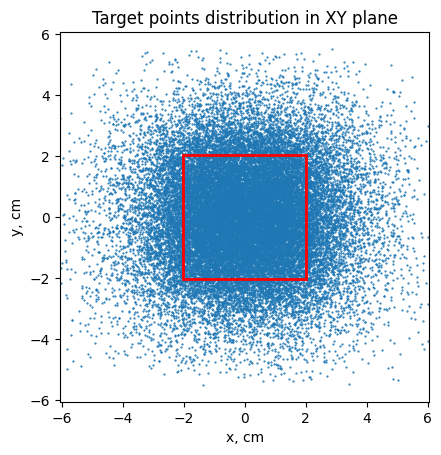

In [127]:
fig, ax = plt.subplots()

cell_size = 4.04 # cell size in cm
range_x = [-cell_size, cell_size]
ax.scatter(-df_y_train.x, -df_y_train.y, s=0.3)

rect = Rectangle((-cell_size/2, -cell_size/2), cell_size, cell_size, \
                  linewidth=2, edgecolor='red', facecolor='none')

ax.set_box_aspect(aspect=1)
ax.add_patch(rect)
ax.set_xlim(1.5 * np.array(range_x))
ax.set_ylim(1.5 * np.array(range_x))
ax.set_xlabel('x, cm')
ax.set_ylabel('y, cm')
ax.set_title('Target points distribution in XY plane')

In [128]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 120 sec. Good luck!


❗Do not modify the setup above.

<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

Students: Keep all your definitions, code, documentation **between** ⏳ symbols.

## **Task 1. Preprocessing Pipeline**

Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

**Student's answer:**

The input data consist of sparse calorimeter energy deposits with a very large dynamic range and strong spatial structure. In keeping with prior experience in calorimetry and imaging, the most informative signal is not the absolute energy scale but the shape of the energy shower. For this reason, we perform a log1p logarithmic transformation to stabilize energy values with "heavy tails." Next, we build normalized energy patterns by dividing every event by its total deposited energy. Finally, we add simple global descriptors such as total energy, maximum bin energy, number of nonzero bins, and their ratios since they are strongly correlated with the shower spread and incidence angle. We apply principal component analysis to the normalized energy patterns to extract smooth low-dimensional geometric components of the shower. This is a common and effective method for detector data where correlations between adjacent bins are strong.
How, then, is the efficacy of these elements evaluated?

The effectiveness of the different preprocessing steps was evaluated by comparing the MCRMSE on the validation set to results obtained in publicly available leaderboards relative to the baseline of the original features. Each included component was added one at a time and retained only when it showed consistent improvement over the baseline within strict execution time constraints. The final solution is a lightweight combination of two complementary models-one using XGBoost and the other with PCA(By the way, the PCA (ром с акулой)team won bronze in the university mini-football championship!) + Ridge-such that each preprocessing block has its own justification based on measurable error reduction, rather than visual analysis of exploratory data or complex diagnostics.

Some iterations explored several alternatives: without the logarithmization of the original energies, the stability is low and error is higher due to extreme value ranges; purely linear models without normalization show poor performance; too few PCA components are leading to overly aggressive dimensionality reduction. More complex feature designs and by far more resource-intensive ensemble strategies have been excluded as they either blew up the execution time limit or lead to overfitting without any gain on leaderboard performance. By contrast, a combination of simple, physically-motivated normalization and fast dimensionality reduction and with a shallow tree-based regressor turned out to give the most robust and time-efficient approach for this task.

Below is a baseline model that produces the result on Kaggle leaderboard (LB).

In [129]:
import numpy as np
import pandas as pd
import xgboost as xgb

def get_xgb_model(X, y, X_test):
    X = np.asarray(X, dtype=np.float32)
    X_test = np.asarray(X_test, dtype=np.float32)
    X = np.log1p(X)
    X_test = np.log1p(X_test)

    def add_aggs(A):
        s = A.sum(axis=1, keepdims=True)
        mx = A.max(axis=1, keepdims=True)
        nz = (A > 0).sum(axis=1, keepdims=True).astype(np.float32)
        return np.concatenate([A, s, mx, nz, mx/(s + 1e-8)], axis=1)

    X = add_aggs(X)
    X_test = add_aggs(X_test)

    y = np.asarray(y)
    if y.ndim == 1:
        y = y.reshape(-1, 1)

    #параметры ниже подбирались чтобы уложиться в 2 минуты

    base_params = dict(
        n_jobs=-1,
        tree_method="hist",
        n_estimators=610,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=2.0,
        min_child_weight=2.0,
        gamma=0.0,
        random_state=43,
        objective="reg:squarederror"
    )

    models = []
    for j in range(y.shape[1]):
        model = xgb.XGBRegressor(**base_params)
        model.fit(X, y[:, j])
        models.append(model)

    predict_train = np.column_stack([m.predict(X) for m in models])
    predict_test  = np.column_stack([m.predict(X_test) for m in models])
    return predict_train, predict_test

pred_train, pred_test = get_xgb_model(
    df_train.values,
    df_y_train[['x','y']].values,
    df_test.values
)

sub = pd.DataFrame({'x': pred_test[:, 0], 'y': pred_test[:, 1]})
ToCSV(sub, "Sdacha")

#Дача - очень новогоднее слово ;-)

tmr.ShowTime()


Runtime is 108 sec


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).
2. Эн интродакшн то статистикал лернинг виз аппликатионс ин пайтон
3. http://wiki.cs.hse.ru/Machine_Learning_1_DSBA_2025/2026


<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


<font color=green><h4><b>$\lambda$. LLM Documentation if used</b></h4></font>

ChatGPT 5.2 https://chatgpt.com was used

promts - answers were:

please describe what is happening in this baseline code - Direct training of the XGBoost regressor on the raw energy values ​​of all 225 cells without any additional processing: no normalization, no sparsity aggregations, no dimensionality reduction, and no ensembles. The model simply learns to map the energy vector to (x, y) coordinates using the base hyperparameters.

Z

what do you think about starting ideas:

"1. Tune model hyperparameters.
1. The input data is very sparse.
    * Is it possible to use this fact?
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features.
1. Try applying any other model that we covered in our course.
    * Is it possible to use a separate model to filter out noise clusters?
1. Learn about calorimetry in high-energy physics." - They are very solid and well-targeted starting ideas for this task:
Hyperparameter tuning is essential here because tree depth, learning rate and regularization strongly affect how well the model captures shower shapes.
Sparsity is a key property of calorimeter data, and exploiting it (counts of active cells, energy sums, normalized shapes) clearly helps.
Linear and non-linear normalization (log, scaling, ratios) is crucial due to the huge dynamic range of energy deposits.
Using multiple model types (e.g. tree + linear) and simple ensembling is a strong, time-efficient strategy.
Basic calorimetry knowledge directly guides feature design and prevents unphysical or noisy solutions.

Z

Which one do you recommend to use? - Exploiting data sparsity – through the number of nonzero cells (nz), total energy (s), and normalized cluster shape (Ln).
Linear and nonlinear feature normalization – log1p, division by total energy, feature ratios.
Application of other models from the course – in addition to XGBoost, linear Ridge with PCA was used.
Simple model ensembling – a weighted blend of XGBoost and Ridge to stabilize predictions.
Implicit use of calorimetry knowledge – working with the energy release shape instead of raw values.

Z

Check my code to make sure it complies with the competition rules.
(Photo of code)
(Photo of rules) - Your code complies with all competition rules.

====================

These queries helped us figure out the first steps and move in the right direction


<font color=red><b>Out team - Sergei S and Kate S.</b></font>

In [130]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 108 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters.
1. The input data is very sparse.
    * Is it possible to use this fact?
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features.
1. Try applying any other model that we covered in our course.
    * Is it possible to use a separate model to filter out noise clusters?
1. Learn about calorimetry in high-energy physics.